In [142]:
import numpy as np
from matplotlib import pyplot as plt
import GPy
from scipy.stats import multivariate_normal as mvn
import pandas as pd


### Helper functions

In [4]:
# simulation function
def foo(X, m=8.6928, s=2.4269):
    #if(is.null(nrow(X))) X <- matrix(X, nrow=1)
    x1 = 4*X[:,0] - 2
    x2 = 4*X[:,1] - 2
    a = 1 + ((x1 + x2 + 1)**2) * (19 - 14*x1 + 3*(x1**2) - 14*x2 + 6*x1*x2 + 3*(x2**2))
    b = 30 + ((2*x1 - 3*x2)**2) * (18 - 32*x1 + 12*(x1**2) + 48*x2 - 36*x1*x2 + 27*(x2**2))
    f = np.log(a*b)
    f = (f-m)/s + np.random.normal(loc=1, scale=0.1, size=1)
    return f

# scaling function
def to_native(x, lb, ub):
    x_native = np.empty_like(x)
    for i in range(x.shape[1]): 
        x_native[:, i] = lb[i] + x[:, i] * (ub[i] - lb[i])
    return x_native


def TS_npoints(model, npoints, Xgrid, inflate_factor=2):
        
    #' Batch Bayesian optimization using Thompson sampling
    #'
    #' @param model an object of class `hetGP`; e.g., as returned by `mleHetGP`
    #' @param npoints an integer representing the desired number of samples
    #' @param Xgrid a matrix of locations at which the samples are drawn
    #'
    #' @return a matrix containing the `npoints` best locations where next batch of simulations should be run

    pred_mean, pred_cov = model.predict(Xgrid, full_cov=True)
    cov_mtx = 0.5 * (pred_cov + pred_cov.T)
    tTS = mvn.rvs(mean=pred_mean.reshape(-1), cov=cov_mtx, size=npoints * 2)
    best_ids = list(set(np.argmin(tTS, axis=1)))[:npoints]
    return Xgrid[best_ids]



### Initial design and search space
We set a lattice grid in the unit box, which the minimizer of `foo` will be searched over. 20 points among those 1000 are randomlypicked to evaluate to start the optimization.

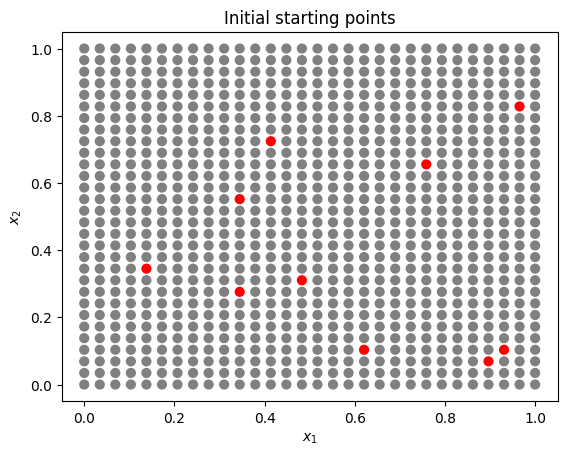

In [165]:
xx = np.linspace(0, 1, 30)
Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)

n1 = 10
N = Xgrid.shape[0]
init_id = np.random.choice(N, n1, replace=False)

# color selected points
col_vec = np.array(['grey'] * N)
col_vec[init_id] = 'red'

plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=col_vec, s=40)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Initial starting points')
plt.show()

### Batch Bayesian Optimization with Thompson Sampling

>> iter = 0 | current best value = -1.0005529864657894 at x1 = 0.48275862068965514, x2 = 0.3103448275862069
>> iter = 1 | current best value = -1.241531191848881 at x1 = 0.4482758620689655, x2 = 0.20689655172413793
>> iter = 2 | current best value = -1.241531191848881 at x1 = 0.4482758620689655, x2 = 0.20689655172413793
>> iter = 3 | current best value = -1.8428695310800716 at x1 = 0.5172413793103449, x2 = 0.27586206896551724
>> iter = 4 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 5 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 6 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 7 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 8 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 9 | current best value = 

 /Users/abbystevens/.virtualenvs/da/lib/python3.11/site-packages/scipy/stats/_multivariate.py:758: RuntimeWarning:covariance is not positive-semidefinite.


>> iter = 13 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 14 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 15 | current best value = -2.151124879602664 at x1 = 0.5172413793103449, x2 = 0.24137931034482757
>> iter = 16 | current best value = -2.1710727308595157 at x1 = 0.48275862068965514, x2 = 0.24137931034482757
>> iter = 17 | current best value = -2.1710727308595157 at x1 = 0.48275862068965514, x2 = 0.24137931034482757
>> iter = 18 | current best value = -2.1710727308595157 at x1 = 0.48275862068965514, x2 = 0.24137931034482757
>> iter = 19 | current best value = -2.1710727308595157 at x1 = 0.48275862068965514, x2 = 0.24137931034482757
>> iter = 20 | current best value = -2.1710727308595157 at x1 = 0.48275862068965514, x2 = 0.24137931034482757
>> iter = 21 | current best value = -2.1710727308595157 at x1 = 0.48275862068965514, x2 = 0.24137931034482757
>> iter = 22 | c

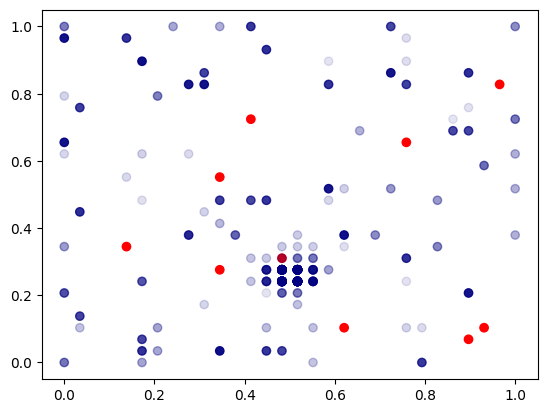

In [168]:
nstep = 30 # times the optimization loop should run
npoints = 10 # size of the batch evaluation in each iteration

# run current designs through function
X = Xgrid[init_id]
X_native = to_native(X, lb=np.array([0, 0]), ub=np.array([1, 1]))
Y = foo(X_native)

# keep track of best 
f_best = []
X_best = np.empty((0, 2))

f_best.append(np.min(Y))
X_best = np.vstack([X_best, X[np.argmin(Y)]])

print(f">> iter = 0 | current best value = {f_best[0]} at x1 = {X_best[0, 0]}, x2 = {X_best[0, 1]}")

# fit GP (note: haven't checked how similar implementation is to the HetGP version, so solutions might be different)
gp = GPy.models.GPRegression(X, Y.reshape(-1,1))
gp.optimize()

for i in np.arange(1, nstep+1):
    X_new = TS_npoints(model = gp, npoints = npoints, Xgrid = Xgrid)
    X_new_native = to_native(X_new, lb = [0, 0], ub = [1, 1])
    Y_new = foo(X_new_native)

    # append to existing best
    X = np.vstack([gp.X, X_new])
    Y = np.vstack([gp.Y, Y_new.reshape(-1,1)])

    # update GP with new data
    #gp.set_XY(X, Y)
    gp = GPy.models.GPRegression(X, Y.reshape(-1,1))
    gp.optimize()

    best_ix = np.argmin(Y)
    f_best.append(Y[best_ix][0])
    X_best = np.vstack([X_best, X[best_ix]])

    print(f">> iter = {i} | current best value = {f_best[i]} at x1 = {X_best[i, 0]}, x2 = {X_best[i, 1]}")

# Plot sequential trajectory
clist = ['red']*n1 + ['navy']*(X.shape[0]-n1)
alist = [1]*n1 + list(np.linspace(.1, 1, X.shape[0]-n1))
                       
plt.scatter(X[:,0], X[:,1], alpha=alist, c=clist)
plt.show()

### Actual solution

<Axes: xlabel='x1', ylabel='x2'>

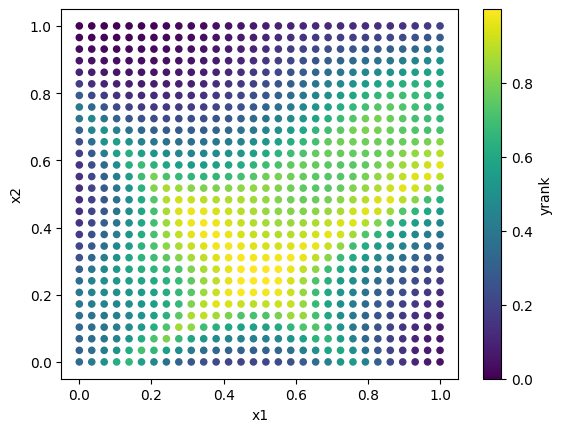

In [171]:
df = pd.DataFrame(Xgrid, columns=['x1', 'x2'])
df['y'] = foo(Xgrid)
df['yrank'] = 1 - df.y.rank()/df.shape[0]

df.plot.scatter('x1', 'x2', c='yrank')